##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 高度な自動微分

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/guide/advanced_autodiff"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/advanced_autodiff.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/advanced_autodiff.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/advanced_autodiff.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

[勾配と自動微分の基礎](autodiff.ipynb)には、TensorFlow での勾配の計算に必要なものがすべて含まれています。このガイドでは、`tf.GradientTape` API のさらに深い、あまり一般的ではない機能に焦点を当てていきます。

## セットアップ

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)

2022-12-14 20:58:19.405350: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:58:19.405454: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:58:19.405464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 勾配の記録を制御する

[自動微分ガイド](autodiff.ipynb)では、勾配計算の作成中にテープが監視する対象の変数とテンソルを制御する方法について説明しました。

テープには、記録を操作するメソッドもあります。

### 記録を停止する

勾配の記録を停止したい場合には、`tf.GradientTape.stop_recording`を使用して一時的に記録を停止することができます。

これは、モデルの途中で複雑な演算を微分を行いたくない場合、オーバーヘッドの削減に有用です。これにはメトリックの計算や、中間結果の計算が含まれます。

In [3]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  x_sq = x * x
  with t.stop_recording():
    y_sq = y * y
  z = x_sq + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


### 記録をリセットまたは最初から録画し直す

最初からやり直す場合は、`tf.GradientTape.reset` を使用してください。通常は勾配テープブロックを終了して再起動した方が読み取りやすくなりますが、テープブロックの終了が困難または不可能な場合は、`reset` メソッドを使用できます。

In [4]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)
reset = True

with tf.GradientTape() as t:
  y_sq = y * y
  if reset:
    # Throw out all the tape recorded so far.
    t.reset()
  z = x * x + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


## 勾配フローを正確に停止する

上記のグローバルなテープ制御とは対照的に、`tf.stop_gradient`関数ははるかに正確です。これはテープ自体にアクセスする必要がなく、勾配が特定のパスに沿って流れることを防ぐために使用できます。

In [5]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  y_sq = y**2
  z = x**2 + tf.stop_gradient(y_sq)

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


## カスタム勾配

場合によっては、デフォルトを使用しないで勾配の計算方法を正確に制御する必要があります。次のような状況がそれに該当します。

1. 記述中の新しい演算に勾配が定義されていない。
2. デフォルトの計算が数値的に不安定。
3. フォワードパスから高価な計算をキャッシュしたい。
4. 勾配を変更せずに値を変更したい（`tf.clip_by_value` や `tf.math.round` などを使用）。

最初のケースでは、新しい演算子を記述するために、`tf.RegisterGradient` を使用して独自の勾配を設定できます（詳細は API ドキュメントを参照）。（勾配レジストリはグローバルなので、注意して変更してください。）

後者の 3 つのケースには、`tf.custom_gradient`を使用できます。

以下は、中間勾配に `tf.clip_by_norm` を適用した例です。

In [6]:
# Establish an identity operation, but clip during the gradient pass.
@tf.custom_gradient
def clip_gradients(y):
  def backward(dy):
    return tf.clip_by_norm(dy, 0.5)
  return y, backward

v = tf.Variable(2.0)
with tf.GradientTape() as t:
  output = clip_gradients(v * v)
print(t.gradient(output, v))  # calls "backward", which clips 4 to 2

tf.Tensor(2.0, shape=(), dtype=float32)


詳細については、`tf.custom_gradient` デコレータの API ドキュメントをご覧ください。

### SavedModel のカスタム勾配

注意: この機能は TensorFlow 2.6 以降で利用できます。

カスタム勾配は、`tf.saved_model.SaveOptions(experimental_custom_gradients=True)` オプションを使用して、SavedModel に保存することができます。

SavedModel に保存できるようにするには、勾配関数はトレース可能である必要があります（詳細は、「[tf.function によるパフォーマンスの改善](function.ipynb)」ガイドをご覧ください）。

In [7]:
class MyModule(tf.Module):

  @tf.function(input_signature=[tf.TensorSpec(None)])
  def call_custom_grad(self, x):
    return clip_gradients(x)

model = MyModule()

In [8]:
tf.saved_model.save(
    model,
    'saved_model',
    options=tf.saved_model.SaveOptions(experimental_custom_gradients=True))

# The loaded gradients will be the same as the above example.
v = tf.Variable(2.0)
loaded = tf.saved_model.load('saved_model')
with tf.GradientTape() as t:
  output = loaded.call_custom_grad(v * v)
print(t.gradient(output, v))

INFO:tensorflow:Assets written to: saved_model/assets


tf.Tensor(2.0, shape=(), dtype=float32)


上記の例に関する注意事項: 上記のコードを `tf.saved_model.SaveOptions(experimental_custom_gradients=False)` に置き換えても、勾配は読み込み時に同じ結果を生成します。これは、勾配のレジストリに `call_custom_op` 関数で使用されたカスタム勾配がまだ含まれているためです。ただし、カスタム勾配なしで保存した後にランタイムを再起動すると、読み込まれたモデルを `tf.GradientTape` で実行したときに `LookupError: No gradient defined for operation 'IdentityN' (op type: IdentityN)` というエラーがスローされます。

## 複数のテープ

複数のテープはシームレスに連携します。

たとえば、ここでは各テープが異なるテンソルのセットをウォッチしています。

In [9]:
x0 = tf.constant(0.0)
x1 = tf.constant(0.0)

with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
  tape0.watch(x0)
  tape1.watch(x1)

  y0 = tf.math.sin(x0)
  y1 = tf.nn.sigmoid(x1)

  y = y0 + y1

  ys = tf.reduce_sum(y)

In [10]:
tape0.gradient(ys, x0).numpy()   # cos(x) => 1.0

1.0

In [11]:
tape1.gradient(ys, x1).numpy()   # sigmoid(x1)*(1-sigmoid(x1)) => 0.25

0.25

### 高次勾配

`tf.GradientTape` コンテキストマネージャー内の演算は、自動微分のために記録されます。そのコンテキストで勾配が計算される場合は、勾配の計算も記録されます。その結果、まったく同じ API が高次勾配にも機能します。

以下に例を示します。

In [12]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    y = x * x * x

  # Compute the gradient inside the outer `t2` context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t1.gradient(y, x)
d2y_dx2 = t2.gradient(dy_dx, x)

print('dy_dx:', dy_dx.numpy())  # 3 * x**2 => 3.0
print('d2y_dx2:', d2y_dx2.numpy())  # 6 * x => 6.0

dy_dx: 3.0
d2y_dx2: 6.0


これにより、*スカラー*関数の 2 次導関数が得られますが、`tf.GradientTape.gradient` はスカラーの勾配のみを計算するため、このパターンはヘッセ行列を生成するための一般化を行いません。[ヘッセ行列](https://en.wikipedia.org/wiki/Hessian_matrix)を作成するには、[ヘッセ行列の例](#hessian)（[ヤコビアンのセクション](#jacobians)）をご覧ください。

「`tf.GradientTape.gradient`のネストされた呼び出し」は、勾配からスカラーを計算する場合に適したパターンです。次の例のように、結果のスカラーは 2 番目の勾配計算のソースとして機能します。


#### 例: 入力勾配の正則化

多くのモデルは「敵対的な例」の影響を受けやすいものです。そのような手法の数々は、モデルの入力を変更してモデルの出力を混乱させます。[Fast Gradient Signed Method 攻撃を使った敵対的な例](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm)といった最も単純な実装は、入力に対する出力の勾配に沿って 1 つのステップを踏む「入力勾配」です。

敵対的な例に対する堅牢性を高める 1 つの手法は、入力勾配のマグニチュードの最小化を試みる、[入力勾配の正則化](https://arxiv.org/abs/1905.11468)（Finlay &amp; Oberman、2019 年）です。入力勾配が小さければ、出力の変化も小さくなるはずです。

下記は、入力勾配の正則化の単純な実装です。実装は次のとおりです。

1. 内部テープを使用して、入力に対する出力の勾配を計算する。
2. その入力勾配の大きさを計算する。
3. モデルに対する大きさの勾配を計算する。

In [13]:
x = tf.random.normal([7, 5])

layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

In [14]:
with tf.GradientTape() as t2:
  # The inner tape only takes the gradient with respect to the input,
  # not the variables.
  with tf.GradientTape(watch_accessed_variables=False) as t1:
    t1.watch(x)
    y = layer(x)
    out = tf.reduce_sum(layer(x)**2)
  # 1. Calculate the input gradient.
  g1 = t1.gradient(out, x)
  # 2. Calculate the magnitude of the input gradient.
  g1_mag = tf.norm(g1)

# 3. Calculate the gradient of the magnitude with respect to the model.
dg1_mag = t2.gradient(g1_mag, layer.trainable_variables)

In [15]:
[var.shape for var in dg1_mag]

[TensorShape([5, 10]), TensorShape([10])]

## ヤコビアン


前述したすべての例では、複数または単一のソーステンソルに対し、単一のスカラーターゲットの勾配を取得しました。

[ヤコビ行列](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)は、ベクトル値関数の勾配を表します。各行には、それぞれベクトルの一要素の勾配が示されます。

`tf.GradientTape.jacobian`メソッドを使用すると、ヤコビ行列を効率的に計算することができます。

注意点:

- `gradient`と同様、`sources`引数は単一のテンソル、またはテンソルのコンテナである可能性があります。
- `gradient`と異なり、`target`テンソルは単一のテンソルでなければなりません。

### スカラーのソース

最初の例は、ここにスカラーソースに対するベクトルターゲットのヤコビアンです。

In [16]:
x = tf.linspace(-10.0, 10.0, 200+1)
delta = tf.Variable(0.0)

with tf.GradientTape() as tape:
  y = tf.nn.sigmoid(x+delta)

dy_dx = tape.jacobian(y, delta)

スカラーに対してヤコビアンをとると、結果は**ターゲット**の形状を持ち、ソースに対する各要素の勾配を表します。

In [17]:
print(y.shape)
print(dy_dx.shape)

(201,)
(201,)


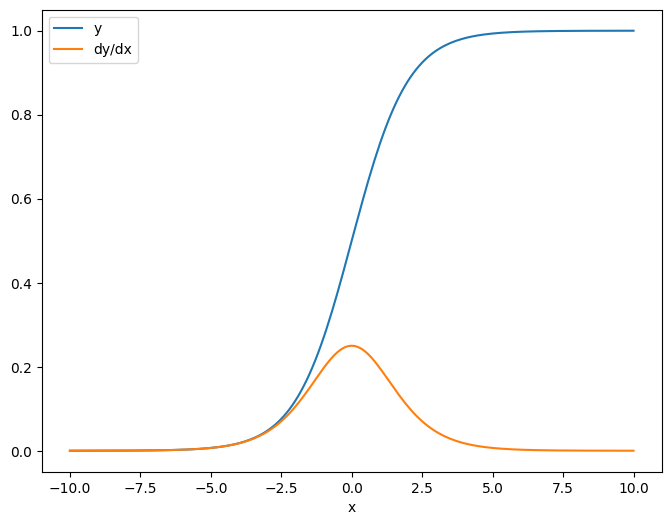

In [18]:
plt.plot(x.numpy(), y, label='y')
plt.plot(x.numpy(), dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

### テンソルのソース

入力がスカラーとテンソルのどちらであっても、`tf.GradientTape.jacobian` は、単一または複数のターゲットの各要素に対するソースの各要素の勾配を効果的に計算します。

たとえば、このレイヤーの出力の形状は `(10, 7)` です。

In [19]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape(persistent=True) as tape:
  y = layer(x)

y.shape

TensorShape([7, 10])

そしてレイヤーのカーネルの形状は`(5, 10)`です。

In [20]:
layer.kernel.shape

TensorShape([5, 10])

カーネルの出力のヤコビアンの形状は、次の 2 つの形状を連結したものです。

In [21]:
j = tape.jacobian(y, layer.kernel)
j.shape

TensorShape([7, 10, 5, 10])

ターゲットの次元を合計すると、`tf.GradientTape.gradient` によって計算された合計の勾配が残ります。

In [22]:
g = tape.gradient(y, layer.kernel)
print('g.shape:', g.shape)

j_sum = tf.reduce_sum(j, axis=[0, 1])
delta = tf.reduce_max(abs(g - j_sum)).numpy()
assert delta < 1e-3
print('delta:', delta)

g.shape: (5, 10)
delta: 4.7683716e-07


<a id="hessian"> </a>

#### 例: ヘッセ行列（Hessian）

`tf.GradientTape` には[ヘッセ行列](https://en.wikipedia.org/wiki/Hessian_matrix)を作成するための明示的なメソッドがありませんが、`tf.GradientTape.jacobian` を使用してこれを作成することは可能です。

注意: ヘッセ行列には `N**2` 個のパラメータが含まれています。これやその他の理由により、ほとんどのモデルには非実用的です。あくまでも `GradientTape.jacobian` メソッドの使い方のデモンストレーションとしてこの例を含めましたが、直接のヘッセ行列ベースの最適化を推奨するものではありません。ヘッセ行列のベクトル積は[ネストされたテープで効率的に計算できる](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/eager/benchmarks/resnet50/hvp_test.py)ため、2 次最適化の方法としては、はるかに効率的です。

In [23]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)

In [24]:
print(f'layer.kernel.shape: {layer1.kernel.shape}')
print(f'h.shape: {h.shape}')

layer.kernel.shape: (5, 8)
h.shape: (5, 8, 5, 8)


このヘッセ行列をニュートン法のステップに使用するには、まず軸を平坦化して行列にし、勾配を平坦化してベクトルにします。

In [25]:
n_params = tf.reduce_prod(layer1.kernel.shape)

g_vec = tf.reshape(g, [n_params, 1])
h_mat = tf.reshape(h, [n_params, n_params])

ヘッセ行列は必ず対称行列になります。

In [26]:
def imshow_zero_center(image, **kwargs):
  lim = tf.reduce_max(abs(image))
  plt.imshow(image, vmin=-lim, vmax=lim, cmap='seismic', **kwargs)
  plt.colorbar()

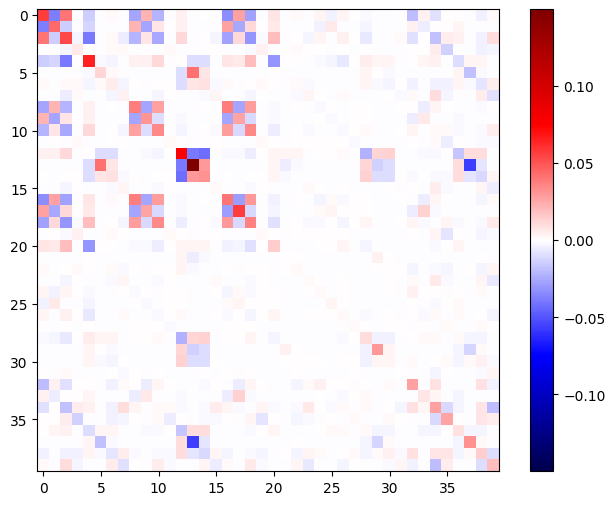

In [27]:
imshow_zero_center(h_mat)

ニュートン法の更新ステップを以下に示します。

In [28]:
eps = 1e-3
eye_eps = tf.eye(h_mat.shape[0])*eps

注意: [実際に行列を反転させないでください](https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/)。

In [29]:
# X(k+1) = X(k) - (∇²f(X(k)))^-1 @ ∇f(X(k))
# h_mat = ∇²f(X(k))
# g_vec = ∇f(X(k))
update = tf.linalg.solve(h_mat + eye_eps, g_vec)

# Reshape the update and apply it to the variable.
_ = layer1.kernel.assign_sub(tf.reshape(update, layer1.kernel.shape))

これは、単一の`tf.Variable`の場合には比較的簡単ですが、これを複雑なモデルに適用するには、完全なヘッセ行列を複数の変数にわたって生成するために、注意深い連結とスライスが必要です。

### ヤコビアンをバッチ処理する

場合により、複数のソースの単一スタックに対して、複数のターゲットの各スタックのヤコビアンを取得して、ターゲットとソースの各ペアのヤコビアンを独立させる必要があることがあります。

たとえば、ここでは入力 `x` は `(batch, ins)` の形状をしており、出力 `y` は `(batch, outs)` の形状をしています。


In [30]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = layer2(y)

y.shape

TensorShape([7, 6])

`x` に対する `y` の完全なヤコビアンは、たとえ `(batch, ins, outs)` だけが必要な場合でも、`(batch, ins, batch, outs)` の形状をしています。

In [31]:
j = tape.jacobian(y, x)
j.shape

TensorShape([7, 6, 7, 5])

スタック内の各アイテムの勾配が独立している場合は、このテンソルの`(batch, batch)`スライスはすべて対角行列になります。

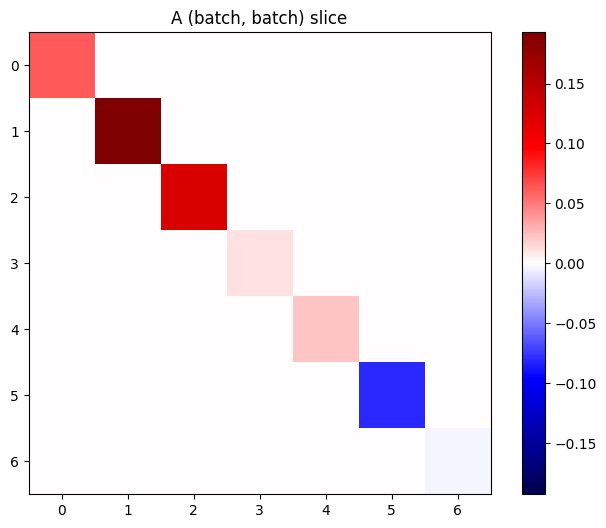

In [32]:
imshow_zero_center(j[:, 0, :, 0])
_ = plt.title('A (batch, batch) slice')

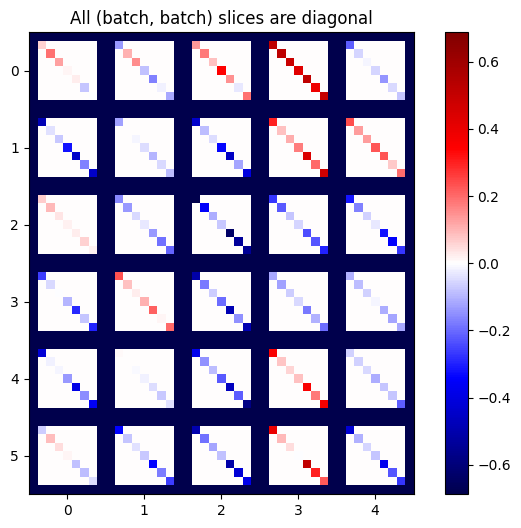

In [33]:
def plot_as_patches(j):
  # Reorder axes so the diagonals will each form a contiguous patch.
  j = tf.transpose(j, [1, 0, 3, 2])
  # Pad in between each patch.
  lim = tf.reduce_max(abs(j))
  j = tf.pad(j, [[0, 0], [1, 1], [0, 0], [1, 1]],
             constant_values=-lim)
  # Reshape to form a single image.
  s = j.shape
  j = tf.reshape(j, [s[0]*s[1], s[2]*s[3]])
  imshow_zero_center(j, extent=[-0.5, s[2]-0.5, s[0]-0.5, -0.5])

plot_as_patches(j)
_ = plt.title('All (batch, batch) slices are diagonal')

期待どおりの結果を得るためには、重複する `batch` 次元を合計するか、`tf.einsum` を使用して対角を選択します。

In [34]:
j_sum = tf.reduce_sum(j, axis=2)
print(j_sum.shape)
j_select = tf.einsum('bxby->bxy', j)
print(j_select.shape)

(7, 6, 5)
(7, 6, 5)


そもそも、余分な次元なしで計算を行う方がはるかに効率的です。`tf.GradientTape.batch_jacobian` メソッドは、まさにそれを行います。

In [35]:
jb = tape.batch_jacobian(y, x)
jb.shape

TensorShape([7, 6, 5])

In [36]:
error = tf.reduce_max(abs(jb - j_sum))
assert error < 1e-3
print(error.numpy())

0.0


注意: `tf.GradientTape.batch_jacobian` は、ソースとターゲットの最初の次元が一致することのみを検証します。勾配が実際に独立していることは確認しません。意味のある場所でのみ `batch_jacobian` を使用できるかは、ユーザー次第です。たとえば、`tf.keras.layers.BatchNormalization` を追加すると、`batch` 次元の全体にわたって正規化するため、独立性は破壊されます。

In [37]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
bn = tf.keras.layers.BatchNormalization()
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = bn(y, training=True)
  y = layer2(y)

j = tape.jacobian(y, x)
print(f'j.shape: {j.shape}')

j.shape: (7, 6, 7, 5)


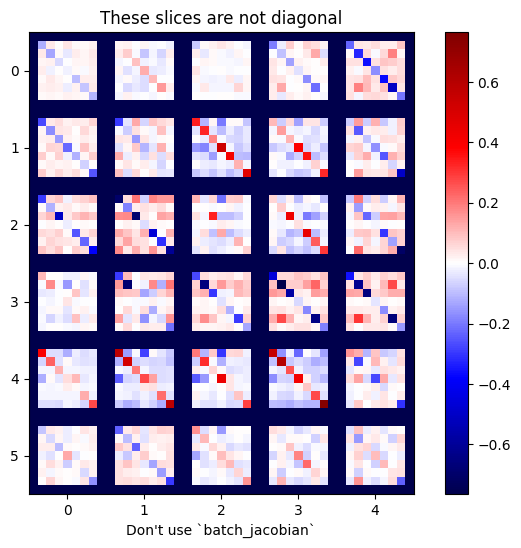

In [38]:
plot_as_patches(j)

_ = plt.title('These slices are not diagonal')
_ = plt.xlabel("Don't use `batch_jacobian`")

この場合、`batch_jacobian` は引き続き実行され、期待される形状の*何か*を返しますが、その内容の意味は不明確です。

In [39]:
jb = tape.batch_jacobian(y, x)
print(f'jb.shape: {jb.shape}')

jb.shape: (7, 6, 5)
